### in this notebook we'll try to make some changes to the vggnet model. instead of pairs of convnets, we'll use just one. (instead of 8 conv layers, we'll use just 4)

vgg model source : github [link](https://github.com/usef-kh/fer/tree/master/models)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os

In [4]:
class FERdataset(Dataset):
    def __init__(self, path_fer2013csv, path_fer2013newcsv):
        self.fer2013 = pd.read_csv(path_fer2013csv)
        self.fer2013labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        self.fer2013new = pd.read_csv(path_fer2013newcsv)
        self.fer2013newlabels = list(self.fer2013new.columns[2:11])
        
    def __getitem__(self, index):
        '''
        returns an image and its fer2013new label as tensors
        '''
        image = self.fer2013['pixels'].iloc[index]
        image = np.fromstring(image, sep=' ').reshape(48, 48)
        image = torch.tensor(image, dtype=torch.float32) / 255
        
        label = torch.tensor(self.fer2013new.iloc[index][2:11].values.astype('float32')) / 10
        
        return image, label
        
    def __len__(self):
        return self.fer2013.shape[0]
    

In [5]:
!ls

drive  sample_data


In [6]:
!unzip /content/drive/MyDrive/TSI/Material/Thesis/data/data.zip

Archive:  /content/drive/MyDrive/TSI/Material/Thesis/data/data.zip
   creating: data/
   creating: data/FERplus/
  inflating: data/FERplus/.gitignore  
  inflating: data/FERplus/fer2013new.csv  
   creating: data/fer2013/
  inflating: data/fer2013/.gitignore  
  inflating: data/fer2013/fer2013.csv  
  inflating: data/fer2013/README     
  inflating: data/fer2013/fer2013.bib  
  inflating: data/fer2013/README.md  


In [7]:
!ls

data  drive  sample_data


In [8]:
path_fer2013csv='data/fer2013/fer2013.csv'
path_fer2013newcsv='data/FERplus/fer2013new.csv'
dataset = FERdataset(path_fer2013csv, path_fer2013newcsv)

In [9]:
from torch.utils.data import random_split

In [10]:
traindataset, valdataset, testdataset = random_split(dataset, [int(0.6*len(dataset)), int(0.2*len(dataset)), len(dataset) - (int(0.6*len(dataset)) + int(0.2*len(dataset)))], generator=torch.Generator().manual_seed(42))

In [11]:
print(f'traindataset length: {len(traindataset)}')
print(f'valdataset length: {len(valdataset)}')
print(f'testdataset length: {len(testdataset)}')

traindataset length: 21532
valdataset length: 7177
testdataset length: 7178


In [12]:
len(dataset.fer2013newlabels)

9

In [13]:
class Model5(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        # self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=5, padding=2)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        # self.conv2b = nn.Conv2d(128, 128, 5, padding=2)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        # self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        # self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        # self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        # self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        # self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        # self.bn4b = nn.BatchNorm2d(512)

        # self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin1 = nn.Linear(512 * 3 * 3, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        # self.lin3 = nn.Linear(4096, 7)
        # output size changed to 9 because we're using the fer plus labels, not the fer 2013 labels
        self.lin3 = nn.Linear(4096, 9)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        # x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        # x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        # x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        # x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        
        # x = x.view(-1, 512 * 2 * 2) - replaced by torch.flatten
        x = torch.flatten(x, 1)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))
        x = self.lin3(x)
        
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model5 = Model5().to(device)

In [16]:
model5

Model5(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3a): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4a): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=4608, out_features=4096, bias=True)
  (lin2): Linear(in_features=4096, out_features=4096, bias=True)
  (lin3): Linear(in_features=4096, out_features=9, bias=True)
  (drop): Dropout(p=0.2, inplace=Fal

In [17]:
torch.cuda.is_available()

True

In [18]:
# parameters
epochs = 20
batch_size = 100

In [19]:
trainloader = DataLoader(traindataset, batch_size, shuffle=True)
valloader = DataLoader(valdataset, batch_size, shuffle=True)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters())

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [22]:
running_loss = []
running_val_loss = []
alltrainacc = []
allvalacc = []

print_every = 20
for e in range(epochs):
    for i,(images, labels) in enumerate(trainloader):
        model5.train()
        images.unsqueeze_(1)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model5(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        
        if i%print_every == 0:
            # torch.save(vggmodel.state_dict(), os.path.join('/models', 'decoder-%d.pkl' % i))
            model5.eval()
            with torch.no_grad():
                for j,(valimages, vallabels) in enumerate(valloader):
                    val_loss_list = []
                    valimages.unsqueeze_(1)
                    valimages = valimages.to(device)
                    vallabels = vallabels.to(device)
                    
                    val_output = model5(valimages)
                    val_loss = criterion(val_output, vallabels)

                    val_loss_list.append(val_loss.item())
                    
                    # to calculate training accuracy
                    trueargmax = torch.argmax(labels, dim=1)
                    truelabels = trueargmax.cpu().detach().numpy()
                    predargmax = torch.argmax(output, dim=1)
                    predlabels = predargmax.cpu().detach().numpy()
                    
                    # to calculate validation accuracy
                    valtrueargmax = torch.argmax(vallabels, dim=1)
                    valtruelabels = valtrueargmax.cpu().detach().numpy()
                    valpredargmax = torch.argmax(val_output, dim=1)
                    valpredlabels = valpredargmax.cpu().detach().numpy()                    

                val_loss_avg = sum(val_loss_list) / len(val_loss_list)
                
            # calculate training and validation accuracy
            batchtrainacc = accuracy_score(truelabels, predlabels)
            batchvalacc = accuracy_score(valtruelabels, valpredlabels)
            
            # store the training and validation accuracies 
            alltrainacc.append(batchtrainacc)
            allvalacc.append(batchvalacc)

            running_val_loss.append(val_loss_avg)
            print(f'epoch: {e}, iteration: {i}, loss: {loss.item():.5f}, val_loss: {val_loss_avg:.5f}, acc: {batchtrainacc:.5f}, val_acc: {batchvalacc:.5f}')

epoch: 0, iteration: 0, loss: 2.19785, val_loss: 2.20276, acc: 0.03000, val_acc: 0.32468
epoch: 0, iteration: 20, loss: 1.71688, val_loss: 1.95632, acc: 0.38000, val_acc: 0.40260
epoch: 0, iteration: 40, loss: 1.72299, val_loss: 1.77796, acc: 0.44000, val_acc: 0.41558
epoch: 0, iteration: 60, loss: 1.72765, val_loss: 1.88907, acc: 0.45000, val_acc: 0.36364
epoch: 0, iteration: 80, loss: 1.80276, val_loss: 1.73000, acc: 0.30000, val_acc: 0.33766
epoch: 0, iteration: 100, loss: 1.74292, val_loss: 1.67722, acc: 0.40000, val_acc: 0.41558
epoch: 0, iteration: 120, loss: 1.79910, val_loss: 1.77093, acc: 0.37000, val_acc: 0.27273
epoch: 0, iteration: 140, loss: 1.73436, val_loss: 1.85673, acc: 0.38000, val_acc: 0.33766
epoch: 0, iteration: 160, loss: 1.67704, val_loss: 1.77283, acc: 0.44000, val_acc: 0.40260
epoch: 0, iteration: 180, loss: 1.78755, val_loss: 1.78105, acc: 0.38000, val_acc: 0.35065
epoch: 0, iteration: 200, loss: 1.74988, val_loss: 1.70582, acc: 0.41000, val_acc: 0.36364
epoch

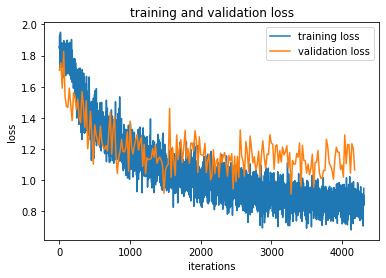

In [23]:
ind = 10
plt.plot(np.arange(len(running_loss[ind:])), running_loss[ind:], label='training loss')
plt.plot(np.arange(len(running_val_loss[ind:]))*print_every, running_val_loss[10:], label='validation loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

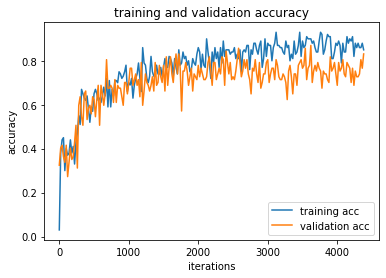

In [24]:
plt.plot(np.arange(len(alltrainacc))*print_every, alltrainacc, label='training acc')
plt.plot(np.arange(len(allvalacc))*print_every, allvalacc, label='validation acc')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

### Let's run the model on the test data

In [25]:
testloader = DataLoader(testdataset, 1, shuffle=False)

In [26]:
model5.eval()
testtruelabels = []
testpredlabels = []
with torch.no_grad():
    for i, (testimage, testlabel) in enumerate(testloader):
        testimage.unsqueeze_(1)
        testimage, testlabel = testimage.to(device), testlabel.to(device)
        testpred = model5(testimage)

        testtrueargmax = torch.argmax(testlabel).item()
        testpredargmax = torch.argmax(testpred).item()

        testtruelabels.append(testtrueargmax)
        testpredlabels.append(testpredargmax)

In [27]:
testconfmat = confusion_matrix(testtruelabels, testpredlabels)

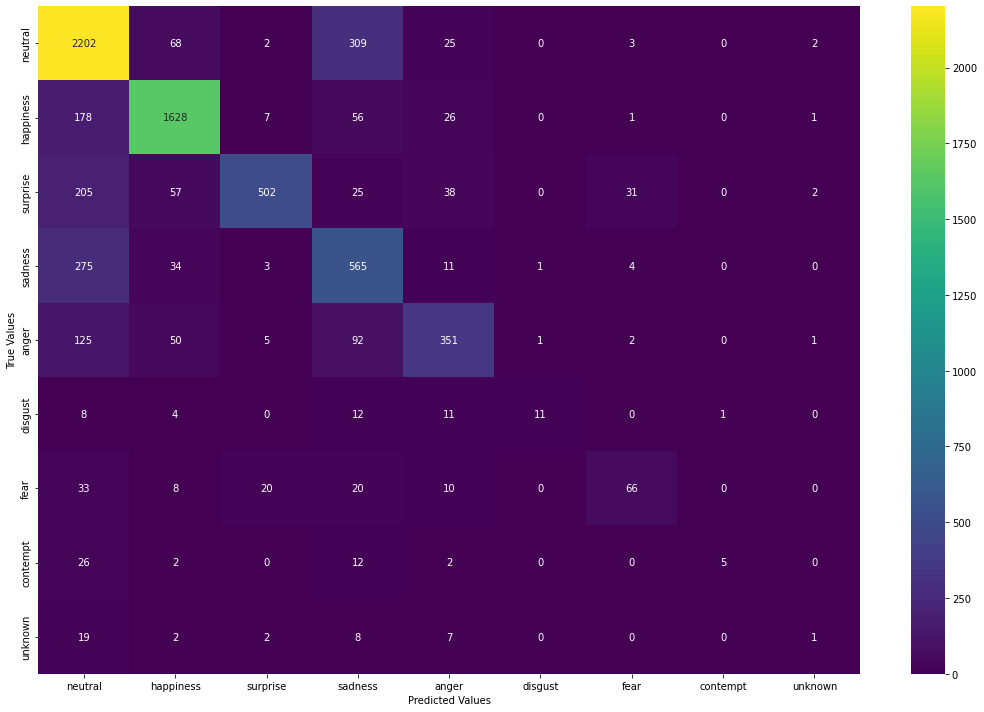

In [28]:
plt.figure(figsize=(15,10))
sns.heatmap(testconfmat, annot=True, fmt='.0f', cmap='viridis', xticklabels=dataset.fer2013newlabels, yticklabels=dataset.fer2013newlabels)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.tight_layout()
plt.show()

In [29]:
accuracy_score(testtruelabels, testpredlabels)

0.7426859849540262

In [30]:
torch.save(model5.state_dict(), f'/content/drive/MyDrive/TSI/Material/Thesis/data/model5_state_dict.pth')